In [1]:
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import gbsg
from BandDeepHitSingle import BandedDeepHitSingle
from pycox.evaluation import EvalSurv

D:\Anaconda\envs\lstm3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#设置种子
# se = random.randint(0,9999)
se = 7420
np.random.seed(se)
_ = torch.manual_seed(se)

In [3]:
#导入数据
dir_path = os.path.dirname('C:\\Users\\gy501\\Desktop\\ReCircle - 英文论文\\ReCircle\\Banded\\')
path = os.path.abspath(os.path.join(dir_path, 'metabric.csv'))
df_train = pd.read_csv(path, index_col=False)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
#处理数据
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [5]:
num_durations = 10
#labtrans = DeepHitSingle.label_transform(num_durations)
labtrans = BandedDeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

In [6]:
train = (x_train, y_train)
val = (x_val, y_val)
# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [7]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

In [8]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
a = 0.2
s = 0.2
model = BandedDeepHitSingle(net, tt.optim.Adam, alpha=a, sigma=s, duration_index=labtrans.cuts)
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
model.optimizer.set_lr(lr_finder.get_best_lr())

In [9]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False
log = model.fit(x_train, y_train, batch_size, epochs, callbacks,verbose,val_data=val)

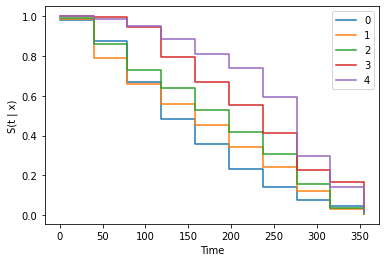

In [10]:
#训练结果
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


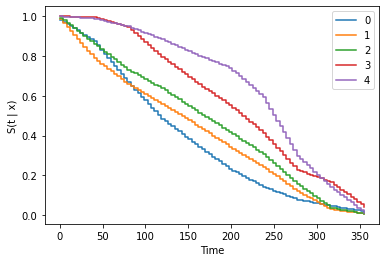

In [11]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.savefig("METABRIC"+str(2)+"-"+str(1)+".png")

In [12]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ci = ev.concordance_td('antolini')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ibs = ev.integrated_brier_score(time_grid)
nbll = ev.integrated_nbll(time_grid) 
ci

0.6637574644005512